# Курсовой проект.

### Задание для курсового проекта

Метрика:
R2 - коэффициент детерминации (sklearn.metrics.r2_score)

Сдача проекта:
1. Прислать в раздел Задания Урока 10 ("Вебинар. Консультация по итоговому проекту")
ссылку на программу в github (программа должна содержаться в файле Jupyter Notebook 
с расширением ipynb). (Pull request не нужен, только ссылка ведущая на сам скрипт).
2. Приложить файл с названием по образцу NVBaranov_predictions.csv
с предсказанными ценами для квартир из test.csv (файл должен содержать два поля: Id, Price).
В файле с предсказаниями должна быть 5001 строка (названия колонок + 5000 предсказаний).

Сроки и условия сдачи:
Дедлайн: сдать проект нужно в течение 72 часов после начала Урока 10 ("Вебинар. Консультация по итоговому проекту").
Для успешной сдачи должны быть все предсказания (для 5000 квартир) и R2 должен быть больше 0.6.
При сдаче до дедлайна результат проекта может попасть в топ лучших результатов.
Повторная сдача и проверка результатов возможны только при условии предыдущей неуспешной сдачи.
Успешный проект нельзя пересдать в целях повышения результата.
Проекты, сданные после дедлайна или сданные повторно, не попадают в топ лучших результатов, но можно узнать результат.
В качестве итогового результата берется первый успешный результат, последующие успешные результаты не учитываются.

Примечание:
Все файлы csv должны содержать названия полей (header - то есть "шапку"),
разделитель - запятая. В файлах не должны содержаться индексы из датафрейма.

Рекомендации для файла с кодом (ipynb):
1. Файл должен содержать заголовки и комментарии
2. Повторяющиеся операции лучше оформлять в виде функций
3. Не делать вывод большого количества строк таблиц (5-10 достаточно)
4. По возможности добавлять графики, описывающие данные (около 3-5)
5. Добавлять только лучшую модель, то есть не включать в код все варианты решения проекта
6. Скрипт проекта должен отрабатывать от начала и до конца (от загрузки данных до выгрузки предсказаний)
7. Весь проект должен быть в одном скрипте (файл ipynb).
8. При использовании статистик (среднее, медиана и т.д.) в качестве признаков,
лучше считать их на трейне, и потом на валидационных и тестовых данных не считать 
статистики заново, а брать их с трейна. Если хватает знаний, можно использовать кросс-валидацию,
но для сдачи этого проекта достаточно разбить данные из train.csv на train и valid.
9. Проект должен полностью отрабатывать за разумное время (не больше 10 минут),
поэтому в финальный вариант лучше не включать GridSearch с перебором 
большого количества сочетаний параметров.
10. Допускается применение любых моделей машинного обучения из библиотеки sklearn.

### Прогнозирование на тестовом датасете

1. Выполнить для тестового датасета те же этапы обработки и постронияния признаков (лучше выполнять действия сразу для двух датасетов)
2. Не потерять и не перемешать индексы от примеров при построении прогнозов
3. Прогнозы должны быть для все примеров из тестового датасета (для всех строк)

**Подключение библиотек и скриптов**

In [1]:
import numpy as np
import pandas as pd
import random

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import KFold, GridSearchCV

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
matplotlib.rcParams.update({'font.size': 14})
pd.set_option('precision', 3)
pd.set_option('max_columns', 100)

In [4]:
def evaluate_preds(train_true_values, train_pred_values, val_true_values, val_pred_values):
    """
    Функция для оценки работы модели
    Parameters:
    train_true_values - целевая переменная из тренировочной части датасета
    train_pred_values - предсказания модели по тренировочной части
    val_true_values - целевая переменная из валидационной части датасета
    val_pred_values - предсказания модели по валидационной части
    Returns:
    R2 на тренировочной и валидационной части, 
    графики зависимости истинных значений от предсказаний
    """
    print("Train R2:\t" + str(round(r2(train_true_values, train_pred_values), 3)))
    print("Valid R2:\t" + str(round(r2(val_true_values, val_pred_values), 3)))
    
    plt.figure(figsize=(18,10))
    
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')
    
    plt.subplot(122)
    sns.scatterplot(x=val_pred_values, y=val_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')
    plt.show()

**Пути к директориям и файлам**

In [5]:
TRAIN_DATASET_PATH = './train.csv'
TEST_DATASET_PATH = './test.csv'

### Загрузка данных

**Описание датасета**

* **Id** - идентификационный номер квартиры
* **DistrictId** - идентификационный номер района
* **Rooms** - количество комнат
* **Square** - площадь
* **LifeSquare** - жилая площадь
* **KitchenSquare** - площадь кухни
* **Floor** - этаж
* **HouseFloor** - количество этажей в доме
* **HouseYear** - год постройки дома
* **Ecology_1, Ecology_2, Ecology_3** - экологические показатели местности
* **Social_1, Social_2, Social_3** - социальные показатели местности
* **Healthcare_1, Helthcare_2** - показатели местности, связанные с охраной здоровья
* **Shops_1, Shops_2** - показатели, связанные с наличием магазинов, торговых центров
* **Price** - цена квартиры

In [6]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
display(train_df.tail())
print(train_df.shape)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
9995,77,32,2.0,50.402,30.476,5.0,6,5.0,1968,0.136,B,B,46,7960,6,350.0,3,11,B,196684.316
9996,6159,18,1.0,41.522,20.539,9.0,13,13.0,2000,0.000,B,B,30,5562,0,NaN,0,5,A,189050.290
9997,5123,27,1.0,47.939,NaN,1.0,12,16.0,2015,0.072,B,B,2,629,1,NaN,0,0,A,159143.805
9998,5400,75,2.0,43.603,33.840,8.0,1,5.0,1961,0.307,B,A,30,5048,9,325.0,2,5,B,181595.340
9999,6306,128,1.0,38.667,21.158,8.0,7,17.0,1990,0.000,B,B,27,4798,0,30.0,2,8,B,218714.078


(10000, 20)


In [7]:
train_df = train_df.set_index('Id')
train_df.head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
Id,,,,,,,,,,,,,,,,,,,
14038,35,2.0,47.982,29.443,6.0,7,9.0,1969,8.904e-02,B,B,33,7976,5,NaN,0,11,B,184966.931
15053,41,3.0,65.684,40.050,8.0,7,9.0,1978,6.999e-05,B,B,46,10309,1,240.0,1,16,B,300009.450
4765,53,2.0,44.948,29.198,0.0,8,12.0,1968,4.964e-02,B,B,34,7759,0,229.0,1,3,B,220925.909
5809,58,2.0,53.353,52.732,9.0,8,17.0,1977,4.379e-01,B,B,23,5735,3,1084.0,0,5,B,175616.227
10783,99,1.0,39.649,23.776,7.0,11,12.0,1976,1.234e-02,B,B,35,5776,1,2078.0,2,4,B,150226.532


In [8]:
test_df = pd.read_csv(TEST_DATASET_PATH)
display(test_df.tail())
print(test_df.shape)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
4995,8180,11,3.0,67.134,50.810,6.0,5,9.0,1973,1.697e-04,B,B,36,5992,0,NaN,1,1,B
4996,4695,1,1.0,40.198,21.807,10.0,12,17.0,2017,7.122e-03,B,B,1,264,0,NaN,0,1,B
4997,5783,12,3.0,77.842,48.283,9.0,23,22.0,1989,9.080e-02,B,B,74,19083,2,NaN,5,15,B
4998,4780,62,2.0,81.305,NaN,0.0,4,0.0,1977,7.216e-02,B,B,2,629,1,NaN,0,0,A
4999,12504,30,2.0,60.556,NaN,1.0,10,17.0,1977,7.815e-05,B,B,22,6398,141,1046.0,3,23,B


(5000, 19)


In [9]:
test_df = test_df.set_index('Id')

In [10]:
test_df.head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
Id,,,,,,,,,,,,,,,,,,
725,58,2.0,49.883,33.433,6.0,6,14.0,1972,0.310,B,B,11,2748,1,NaN,0,0,B
15856,74,2.0,69.263,NaN,1.0,6,1.0,1977,0.076,B,B,6,1437,3,NaN,0,2,B
5480,190,1.0,13.598,15.948,12.0,2,5.0,1909,0.000,B,B,30,7538,87,4702.0,5,5,B
15664,47,2.0,73.047,51.941,9.0,22,22.0,2007,0.102,B,B,23,4583,3,NaN,3,3,B
14275,27,1.0,47.527,43.388,1.0,17,17.0,2017,0.072,B,B,2,629,1,NaN,0,0,A


In [11]:
train_df.shape[1]-1 == test_df.shape[1]

True

In [12]:
#train_and_test_df = train_df
train_and_test_df = pd.concat([train_df, test_df])

In [13]:
display(train_and_test_df.head())
print(train_and_test_df.shape)

,DistrictId,Ecology_1,Ecology_2,Ecology_3,Floor,Healthcare_1,Helthcare_2,HouseFloor,HouseYear,KitchenSquare,LifeSquare,Price,Rooms,Shops_1,Shops_2,Social_1,Social_2,Social_3,Square
Id,,,,,,,,,,,,,,,,,,,
14038,35,8.904e-02,B,B,7,NaN,0,9.0,1969,6.0,29.443,184966.931,2.0,11,B,33,7976,5,47.982
15053,41,6.999e-05,B,B,7,240.0,1,9.0,1978,8.0,40.050,300009.450,3.0,16,B,46,10309,1,65.684
4765,53,4.964e-02,B,B,8,229.0,1,12.0,1968,0.0,29.198,220925.909,2.0,3,B,34,7759,0,44.948
5809,58,4.379e-01,B,B,8,1084.0,0,17.0,1977,9.0,52.732,175616.227,2.0,5,B,23,5735,3,53.353
10783,99,1.234e-02,B,B,11,2078.0,2,12.0,1976,7.0,23.776,150226.532,1.0,4,B,35,5776,1,39.649


(15000, 19)


### Приведение типов

In [14]:
train_df.dtypes

DistrictId         int64
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
Price            float64
dtype: object

In [15]:
test_df.dtypes

DistrictId         int64
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
dtype: object

In [16]:
#train_df['Id'] = train_df['Id'].astype(str)
train_df['DistrictId'] = train_df['DistrictId'].astype(str)
test_df['DistrictId'] = test_df['DistrictId'].astype(str)

In [17]:
train_df['DistrictId'].sort_values().unique()

array(['0', '1', '10', '100', '101', '102', '103', '104', '105', '106',
       '107', '108', '109', '11', '110', '111', '112', '113', '114',
       '115', '116', '117', '118', '119', '12', '120', '121', '122',
       '123', '124', '125', '126', '127', '128', '129', '13', '130',
       '131', '132', '133', '134', '135', '136', '137', '138', '139',
       '14', '140', '141', '142', '143', '144', '145', '146', '147',
       '148', '149', '15', '150', '151', '152', '153', '154', '155',
       '156', '157', '158', '159', '16', '160', '161', '162', '163',
       '164', '165', '166', '167', '168', '169', '17', '170', '171',
       '172', '173', '174', '175', '176', '177', '178', '179', '18',
       '180', '181', '182', '183', '184', '185', '186', '187', '188',
       '189', '19', '190', '191', '192', '193', '194', '195', '196',
       '199', '2', '20', '200', '201', '202', '205', '207', '208', '209',
       '21', '22', '23', '24', '25', '26', '27', '28', '29', '3', '30',
       '31', '32', '3

In [18]:
test_df['DistrictId'].sort_values().unique()

array(['0', '1', '10', '100', '101', '102', '103', '104', '105', '106',
       '107', '108', '109', '11', '110', '111', '112', '113', '114',
       '115', '116', '118', '119', '12', '120', '121', '122', '123',
       '124', '125', '126', '127', '128', '129', '13', '130', '131',
       '132', '134', '135', '136', '137', '138', '139', '14', '140',
       '141', '142', '143', '144', '145', '146', '147', '148', '149',
       '15', '150', '151', '152', '153', '154', '155', '156', '157',
       '159', '16', '160', '161', '163', '164', '165', '166', '167',
       '168', '169', '17', '170', '171', '172', '173', '175', '176',
       '177', '178', '179', '18', '180', '181', '182', '183', '184',
       '185', '186', '187', '188', '189', '19', '190', '191', '192',
       '193', '194', '196', '198', '2', '20', '200', '203', '204', '205',
       '206', '208', '209', '21', '210', '211', '212', '22', '23', '24',
       '25', '26', '27', '28', '29', '3', '30', '31', '32', '33', '34',
       '35', '36',

In [19]:
train_df.head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
Id,,,,,,,,,,,,,,,,,,,
14038,35,2.0,47.982,29.443,6.0,7,9.0,1969,8.904e-02,B,B,33,7976,5,NaN,0,11,B,184966.931
15053,41,3.0,65.684,40.050,8.0,7,9.0,1978,6.999e-05,B,B,46,10309,1,240.0,1,16,B,300009.450
4765,53,2.0,44.948,29.198,0.0,8,12.0,1968,4.964e-02,B,B,34,7759,0,229.0,1,3,B,220925.909
5809,58,2.0,53.353,52.732,9.0,8,17.0,1977,4.379e-01,B,B,23,5735,3,1084.0,0,5,B,175616.227
10783,99,1.0,39.649,23.776,7.0,11,12.0,1976,1.234e-02,B,B,35,5776,1,2078.0,2,4,B,150226.532


In [20]:
test_df.head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
Id,,,,,,,,,,,,,,,,,,
725,58,2.0,49.883,33.433,6.0,6,14.0,1972,0.310,B,B,11,2748,1,NaN,0,0,B
15856,74,2.0,69.263,NaN,1.0,6,1.0,1977,0.076,B,B,6,1437,3,NaN,0,2,B
5480,190,1.0,13.598,15.948,12.0,2,5.0,1909,0.000,B,B,30,7538,87,4702.0,5,5,B
15664,47,2.0,73.047,51.941,9.0,22,22.0,2007,0.102,B,B,23,4583,3,NaN,3,3,B
14275,27,1.0,47.527,43.388,1.0,17,17.0,2017,0.072,B,B,2,629,1,NaN,0,0,A


### Обзор данных

**Целевая переменная**

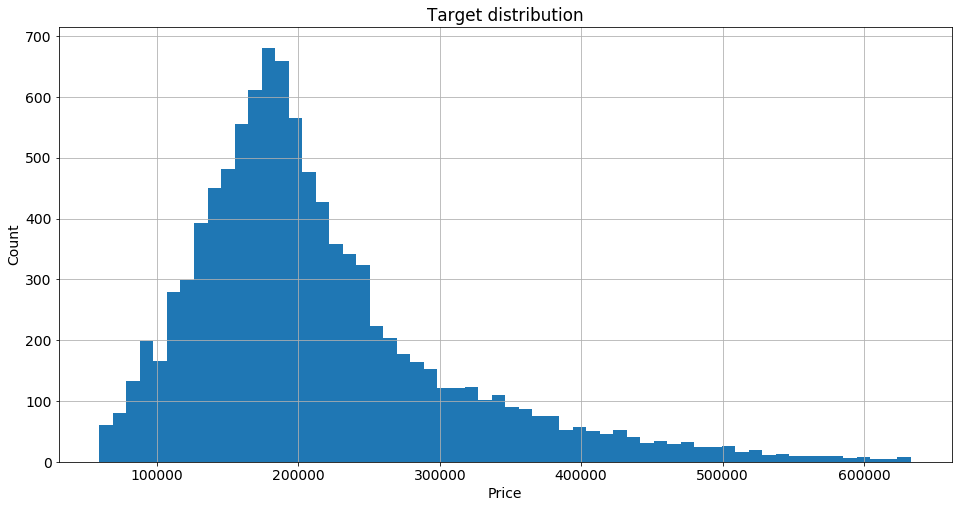

In [21]:
plt.figure(figsize = (16, 8))

train_df['Price'].hist(bins=60)
plt.ylabel('Count')
plt.xlabel('Price')
plt.title('Target distribution')
plt.show()

**Количественные переменные**

In [22]:
train_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Rooms,10000.0,1.891,0.840,0.000,1.000,2.000,2.000,1.900e+01
Square,10000.0,56.316,21.059,1.137,41.775,52.513,65.901,6.411e+02
LifeSquare,7887.0,37.200,86.241,0.371,22.770,32.781,45.129,7.481e+03
KitchenSquare,10000.0,6.273,28.561,0.000,1.000,6.000,9.000,2.014e+03
Floor,10000.0,8.527,5.241,1.000,4.000,7.000,12.000,4.200e+01
HouseFloor,10000.0,12.609,6.776,0.000,9.000,13.000,17.000,1.170e+02
HouseYear,10000.0,3990.166,200500.261,1910.000,1974.000,1977.000,2001.000,2.005e+07
Ecology_1,10000.0,0.119,0.119,0.000,0.018,0.075,0.196,5.219e-01
Social_1,10000.0,24.687,17.533,0.000,6.000,25.000,36.000,7.400e+01
Social_2,10000.0,5352.157,4006.800,168.000,1564.000,5285.000,7227.000,1.908e+04


In [23]:
test_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Rooms,5000.0,1.910,0.839,0.000,1.000,2.000,2.000,17.000
Square,5000.0,56.450,19.093,1.379,41.906,52.921,66.285,223.454
LifeSquare,3959.0,36.159,17.825,0.333,23.092,32.925,45.174,303.071
KitchenSquare,5000.0,5.977,9.950,0.000,1.000,6.000,9.000,620.000
Floor,5000.0,8.632,5.483,1.000,4.000,7.000,12.000,78.000
HouseFloor,5000.0,12.601,6.789,0.000,9.000,12.000,17.000,99.000
HouseYear,5000.0,1984.393,18.573,1908.000,1973.000,1977.000,2000.000,2020.000
Ecology_1,5000.0,0.120,0.120,0.000,0.020,0.072,0.196,0.522
Social_1,5000.0,24.934,17.532,0.000,6.000,25.000,36.000,74.000
Social_2,5000.0,5406.900,4026.615,168.000,1564.000,5285.000,7287.000,19083.000


**Категориальные переменные**

In [24]:
cat_colnames = train_df.select_dtypes(include='object').columns.tolist()
cat_colnames

['DistrictId', 'Ecology_2', 'Ecology_3', 'Shops_2']

In [25]:
for cat_colname in cat_colnames[1:]:
    print(str(cat_colname) + '\n\n' + str(train_df[cat_colname].value_counts()) + '\n' + '*' * 100 + '\n')

Ecology_2

B    9903
A      97
Name: Ecology_2, dtype: int64
****************************************************************************************************

Ecology_3

B    9725
A     275
Name: Ecology_3, dtype: int64
****************************************************************************************************

Shops_2

B    9175
A     825
Name: Shops_2, dtype: int64
****************************************************************************************************



In [26]:
# Не нужно сейчас это делать
#train_df.at[train_df['Ecology_2'] == 'A', 'Ecology_2'] = 1
#train_df.at[train_df['Ecology_2'] == 'B', 'Ecology_2'] = 2

#train_df.at[train_df['Ecology_3'] == 'A', 'Ecology_3'] = 1
#train_df.at[train_df['Ecology_3'] == 'B', 'Ecology_3'] = 2

#train_df.at[train_df['Shops_2'] == 'A', 'Shops_2'] = 1
#train_df.at[train_df['Shops_2'] == 'B', 'Shops_2'] = 2

In [27]:
for cat_colname in cat_colnames[1:]:
    print(str(cat_colname) + '\n\n' + str(train_df[cat_colname].value_counts()) + '\n' + '*' * 100 + '\n')

Ecology_2

B    9903
A      97
Name: Ecology_2, dtype: int64
****************************************************************************************************

Ecology_3

B    9725
A     275
Name: Ecology_3, dtype: int64
****************************************************************************************************

Shops_2

B    9175
A     825
Name: Shops_2, dtype: int64
****************************************************************************************************



In [28]:
train_df.dtypes

DistrictId        object
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
Price            float64
dtype: object

In [29]:
test_df.dtypes

DistrictId        object
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
dtype: object

### Обработка выбросов

**Rooms**

In [30]:
train_df['Rooms'].value_counts()

2.0     3880
1.0     3705
3.0     2235
4.0      150
5.0       18
0.0        8
10.0       2
19.0       1
6.0        1
Name: Rooms, dtype: int64

In [31]:
train_df.loc[train_df['Rooms'].isin([0, 10, 19]), ['Rooms', 'Square','LifeSquare']]

,Rooms,Square,LifeSquare
Id,,,
5927,10.0,59.057,36.223
12638,0.0,138.428,136.215
8491,19.0,42.006,21.779
7917,0.0,212.932,211.231
7317,0.0,41.791,NaN
770,0.0,49.484,NaN
456,0.0,81.491,NaN
3224,0.0,2.377,0.873
3159,0.0,38.697,19.345


In [32]:
# вычисление медианных площадей с группировкой по количеству комнат
df_median_square = pd.DataFrame(train_df.groupby(['Rooms'])['Square'].median())
d1 = df_median_square.reset_index()
df_median_square = d1.loc[(d1['Rooms'] != 19) & (d1['Rooms'] != 10) & (d1['Rooms'] != 0)]
print(df_median_square)

   Rooms   Square
1    1.0   40.407
2    2.0   55.842
3    3.0   77.414
4    4.0   98.668
5    5.0  116.085
6    6.0   59.414


In [33]:
# функция для нахождениея ближайшего количества комнат (определяем по общей площади квартиры)
def pre_rooms (df_mean, is_square, is_rooms):
    df1 = round(abs(df_mean['Square'] - is_square),2)
    if is_rooms in [0,10,17,19]:
        return (df1[df1.where((df1 != df1[df1>0].min()) & 1==1).isnull()].index[0]) 
    else:
        return is_rooms

In [34]:
train_df['Rooms'].value_counts()

2.0     3880
1.0     3705
3.0     2235
4.0      150
5.0       18
0.0        8
10.0       2
19.0       1
6.0        1
Name: Rooms, dtype: int64

In [35]:
# расчет нового количества комнат
train_df['Rooms'] = train_df.apply(lambda x: pre_rooms(df_median_square, x['Square'], x['Rooms']), axis =  1)

In [36]:
test_df['Rooms'] = test_df.apply(lambda x: pre_rooms(df_median_square, x['Square'], x['Rooms']), axis =  1)

In [37]:
train_df['Rooms'].value_counts()

2.0    3881
1.0    3709
3.0    2237
4.0     150
5.0      20
6.0       3
Name: Rooms, dtype: int64

In [38]:
test_df['Rooms'].value_counts()

2.0    2031
1.0    1769
3.0    1100
4.0      90
5.0       8
6.0       2
Name: Rooms, dtype: int64

In [39]:
# старое решение мне не понравилось ...
#train_df.loc[train_df['Rooms'].isin([0, 10, 19]), 'Rooms'] = train_df['Rooms'].median()

**Square, LifeSquare, KitchenSquare**

In [40]:
train_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Rooms,10000.0,1.890,0.816,1.000,1.000,2.000,2.000,6.000e+00
Square,10000.0,56.316,21.059,1.137,41.775,52.513,65.901,6.411e+02
LifeSquare,7887.0,37.200,86.241,0.371,22.770,32.781,45.129,7.481e+03
KitchenSquare,10000.0,6.273,28.561,0.000,1.000,6.000,9.000,2.014e+03
Floor,10000.0,8.527,5.241,1.000,4.000,7.000,12.000,4.200e+01
HouseFloor,10000.0,12.609,6.776,0.000,9.000,13.000,17.000,1.170e+02
HouseYear,10000.0,3990.166,200500.261,1910.000,1974.000,1977.000,2001.000,2.005e+07
Ecology_1,10000.0,0.119,0.119,0.000,0.018,0.075,0.196,5.219e-01
Social_1,10000.0,24.687,17.533,0.000,6.000,25.000,36.000,7.400e+01
Social_2,10000.0,5352.157,4006.800,168.000,1564.000,5285.000,7227.000,1.908e+04


In [41]:
test_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Rooms,5000.0,1.909,0.811,1.000,1.000,2.000,2.000,6.000
Square,5000.0,56.450,19.093,1.379,41.906,52.921,66.285,223.454
LifeSquare,3959.0,36.159,17.825,0.333,23.092,32.925,45.174,303.071
KitchenSquare,5000.0,5.977,9.950,0.000,1.000,6.000,9.000,620.000
Floor,5000.0,8.632,5.483,1.000,4.000,7.000,12.000,78.000
HouseFloor,5000.0,12.601,6.789,0.000,9.000,12.000,17.000,99.000
HouseYear,5000.0,1984.393,18.573,1908.000,1973.000,1977.000,2000.000,2020.000
Ecology_1,5000.0,0.120,0.120,0.000,0.020,0.072,0.196,0.522
Social_1,5000.0,24.934,17.532,0.000,6.000,25.000,36.000,74.000
Social_2,5000.0,5406.900,4026.615,168.000,1564.000,5285.000,7287.000,19083.000


In [42]:
steps = []
scores = [] # <- записываем финальный score

In [43]:
# steps.append('обработка пропусков, выбросов var1')

train_df = train_df[train_df['Square'].isnull() |
                    (train_df['Square'] < train_df['Square'].quantile(.99)) &
                    (train_df['Square'] > train_df['Square'].quantile(.01))]

train_df = train_df[train_df['LifeSquare'].isnull() |
                    (train_df['LifeSquare'] < train_df['LifeSquare'].quantile(.99)) &
                    (train_df['LifeSquare'] > train_df['LifeSquare'].quantile(.01))]

train_df = train_df[train_df['KitchenSquare'].isnull() |
                    (train_df['KitchenSquare'] < train_df['KitchenSquare'].quantile(.99)) &
                    (train_df['KitchenSquare'] > train_df['KitchenSquare'].quantile(.01))]

In [44]:
steps.append('обработка пропусков, выбросов var2')

"""
...
...
...
"""

'\n...\n...\n...\n'

In [45]:
test_df = test_df[test_df['Square'].isnull() |
                    (test_df['Square'] < test_df['Square'].quantile(.99)) &
                    (test_df['Square'] > test_df['Square'].quantile(.01))]

test_df = test_df[test_df['LifeSquare'].isnull() |
                    (test_df['LifeSquare'] < test_df['LifeSquare'].quantile(.99)) &
                    (test_df['LifeSquare'] > test_df['LifeSquare'].quantile(.01))]

test_df = test_df[test_df['KitchenSquare'].isnull() |
                    (test_df['KitchenSquare'] < test_df['KitchenSquare'].quantile(.99)) &
                    (test_df['KitchenSquare'] > test_df['KitchenSquare'].quantile(.01))]

In [46]:
train_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Rooms,8881.0,1.885,0.799,1.000,1.000,2.000,2.000,6.000e+00
Square,8881.0,54.809,16.225,29.720,41.638,51.656,64.721,1.179e+02
LifeSquare,7296.0,34.830,14.281,2.941,22.864,32.460,44.120,8.838e+01
KitchenSquare,8881.0,6.075,3.504,1.000,1.000,6.000,9.000,1.400e+01
Floor,8881.0,8.447,5.134,1.000,4.000,7.000,12.000,4.200e+01
HouseFloor,8881.0,12.827,6.369,0.000,9.000,14.000,17.000,1.170e+02
HouseYear,8881.0,4242.532,212757.076,1914.000,1972.000,1977.000,2000.000,2.005e+07
Ecology_1,8881.0,0.120,0.120,0.000,0.018,0.076,0.194,5.219e-01
Social_1,8881.0,26.071,17.270,0.000,10.000,25.000,36.000,7.400e+01
Social_2,8881.0,5630.480,3977.903,168.000,2370.000,5562.000,7614.000,1.908e+04


In [47]:
train_df.loc[train_df['LifeSquare'] < 10, 'LifeSquare'] = 10

In [48]:
train_df.loc[train_df['KitchenSquare'] < 3, 'KitchenSquare'] = 3

In [49]:
test_df.loc[test_df['LifeSquare'] < 10, 'LifeSquare'] = 10

In [50]:
test_df.loc[test_df['KitchenSquare'] < 3, 'KitchenSquare'] = 3

In [51]:
train_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Rooms,8881.0,1.885,0.799,1.000,1.000,2.000,2.000,6.000e+00
Square,8881.0,54.809,16.225,29.720,41.638,51.656,64.721,1.179e+02
LifeSquare,7296.0,34.909,14.127,10.000,22.864,32.460,44.120,8.838e+01
KitchenSquare,8881.0,6.590,2.796,3.000,3.000,6.000,9.000,1.400e+01
Floor,8881.0,8.447,5.134,1.000,4.000,7.000,12.000,4.200e+01
HouseFloor,8881.0,12.827,6.369,0.000,9.000,14.000,17.000,1.170e+02
HouseYear,8881.0,4242.532,212757.076,1914.000,1972.000,1977.000,2000.000,2.005e+07
Ecology_1,8881.0,0.120,0.120,0.000,0.018,0.076,0.194,5.219e-01
Social_1,8881.0,26.071,17.270,0.000,10.000,25.000,36.000,7.400e+01
Social_2,8881.0,5630.480,3977.903,168.000,2370.000,5562.000,7614.000,1.908e+04


In [52]:
test_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Rooms,4447.0,1.906,0.791,1.000,1.000,2.000,2.000,5.000
Square,4447.0,55.151,16.344,30.063,41.775,52.035,65.322,115.008
LifeSquare,3652.0,35.128,14.206,10.000,23.191,32.632,44.306,85.621
KitchenSquare,4447.0,6.562,2.735,3.000,4.000,6.000,9.000,13.000
Floor,4447.0,8.555,5.406,1.000,4.000,7.000,12.000,78.000
HouseFloor,4447.0,12.778,6.337,0.000,9.000,12.000,17.000,99.000
HouseYear,4447.0,1984.030,18.520,1910.000,1972.000,1977.000,1999.000,2020.000
Ecology_1,4447.0,0.120,0.120,0.000,0.020,0.076,0.196,0.522
Social_1,4447.0,26.145,17.301,0.000,11.000,25.000,37.000,74.000
Social_2,4447.0,5644.406,3998.022,168.000,2370.000,5562.000,7614.000,19083.000


**HouseFloor, Floor**

In [53]:
train_df['HouseFloor'].sort_values().unique()

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  32.,  37.,
        39.,  40.,  44.,  45.,  48.,  99., 117.])

In [54]:
train_df['Floor'].sort_values().unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 31, 32, 33, 42],
      dtype=int64)

In [55]:
test_df['HouseFloor'].sort_values().unique()

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
       26., 27., 29., 30., 31., 32., 33., 37., 39., 40., 48., 99.])

In [56]:
test_df['Floor'].sort_values().unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 32, 34, 38, 46, 78],
      dtype=int64)

In [57]:
train_df.loc[train_df['HouseFloor'] == 0, 'HouseFloor'] = train_df['HouseFloor'].median()

In [58]:
test_df.loc[test_df['HouseFloor'] == 0, 'HouseFloor'] = test_df['HouseFloor'].median()

In [59]:
floor_outliers = train_df[train_df['Floor'] > train_df['HouseFloor']].index

train_df.loc[floor_outliers, 'Floor'] = train_df.loc[floor_outliers, 'HouseFloor'].apply(lambda x: random.randint(1, x))


In [60]:
floor_outliers_test = test_df[test_df['Floor'] > test_df['HouseFloor']].index

test_df.loc[floor_outliers_test, 'Floor'] = test_df.loc[floor_outliers_test, 'HouseFloor'].apply(lambda x: random.randint(1, x))

**HouseYear**

In [61]:
train_df['HouseYear'].sort_values().unique()

array([    1914,     1916,     1917,     1918,     1919,     1928,
           1929,     1930,     1931,     1932,     1933,     1934,
           1935,     1936,     1937,     1938,     1939,     1940,
           1941,     1942,     1947,     1948,     1950,     1951,
           1952,     1953,     1954,     1955,     1956,     1957,
           1958,     1959,     1960,     1961,     1962,     1963,
           1964,     1965,     1966,     1967,     1968,     1969,
           1970,     1971,     1972,     1973,     1974,     1975,
           1976,     1977,     1978,     1979,     1980,     1981,
           1982,     1983,     1984,     1985,     1986,     1987,
           1988,     1989,     1990,     1991,     1992,     1993,
           1994,     1995,     1996,     1997,     1998,     1999,
           2000,     2001,     2002,     2003,     2004,     2005,
           2006,     2007,     2008,     2009,     2010,     2011,
           2012,     2013,     2014,     2015,     2016,     2

In [62]:
test_df['HouseYear'].sort_values().unique()

array([1910, 1911, 1912, 1914, 1917, 1918, 1920, 1926, 1927, 1928, 1929,
       1930, 1931, 1932, 1933, 1934, 1935, 1937, 1938, 1939, 1940, 1941,
       1943, 1948, 1949, 1950, 1952, 1953, 1954, 1955, 1956, 1957, 1958,
       1959, 1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969,
       1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980,
       1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991,
       1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002,
       2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013,
       2014, 2015, 2016, 2017, 2018, 2019, 2020], dtype=int64)

In [63]:
train_df.loc[train_df['HouseYear'] == 20052011, 'HouseYear'] = 2005

In [64]:
train_df.loc[train_df['HouseYear'] == 4968, 'HouseYear'] = round(train_df['HouseYear'].median())

In [65]:
train_df['HouseYear'].sort_values().unique()

array([1914, 1916, 1917, 1918, 1919, 1928, 1929, 1930, 1931, 1932, 1933,
       1934, 1935, 1936, 1937, 1938, 1939, 1940, 1941, 1942, 1947, 1948,
       1950, 1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960,
       1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971,
       1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982,
       1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993,
       1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004,
       2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015,
       2016, 2017, 2018, 2019, 2020], dtype=int64)

### Обработка пропусков

In [66]:
train_df.isnull().sum()

DistrictId          0
Rooms               0
Square              0
LifeSquare       1585
KitchenSquare       0
Floor               0
HouseFloor          0
HouseYear           0
Ecology_1           0
Ecology_2           0
Ecology_3           0
Social_1            0
Social_2            0
Social_3            0
Healthcare_1     4082
Helthcare_2         0
Shops_1             0
Shops_2             0
Price               0
dtype: int64

In [67]:
test_df.isnull().sum()

DistrictId          0
Rooms               0
Square              0
LifeSquare        795
KitchenSquare       0
Floor               0
HouseFloor          0
HouseYear           0
Ecology_1           0
Ecology_2           0
Ecology_3           0
Social_1            0
Social_2            0
Social_3            0
Healthcare_1     2039
Helthcare_2         0
Shops_1             0
Shops_2             0
dtype: int64

In [68]:
train_df[['Square', 'LifeSquare', 'KitchenSquare']].head(10)

,Square,LifeSquare,KitchenSquare
Id,,,
14038,47.982,29.443,6.0
15053,65.684,40.050,8.0
5809,53.353,52.732,9.0
10783,39.649,23.776,7.0
12915,80.384,46.684,12.0
14549,62.254,37.160,7.0
5172,64.511,NaN,3.0
8649,46.461,18.916,8.0
15370,46.305,27.923,6.0


In [69]:
test_df[['Square', 'LifeSquare', 'KitchenSquare']].head(10)

,Square,LifeSquare,KitchenSquare
Id,,,
725,49.883,33.433,6.0
15856,69.263,NaN,3.0
15664,73.047,51.941,9.0
14275,47.527,43.388,3.0
7633,40.676,NaN,3.0
13329,68.100,64.843,3.0
5502,48.194,32.858,6.0
4220,72.277,45.969,9.0
11538,80.219,47.660,9.0


**LifeSquare**

In [70]:
# медиана до корректировки
print(train_df['LifeSquare'].median())
print(test_df['LifeSquare'].median())

32.459930868446605
32.631810662086764


In [71]:
# медиана расхождения площадей
square_med_diff = (train_df.loc[train_df['LifeSquare'].notnull(), 'Square']
                   - train_df.loc[train_df['LifeSquare'].notnull(), 'LifeSquare']
                   - train_df.loc[train_df['LifeSquare'].notnull(), 'KitchenSquare']).median()

print(square_med_diff)

11.490551802890103


In [72]:
# медиана расхождения площадей
square_med_diff_test = (test_df.loc[test_df['LifeSquare'].notnull(), 'Square']
                   - test_df.loc[test_df['LifeSquare'].notnull(), 'LifeSquare']
                   - test_df.loc[test_df['LifeSquare'].notnull(), 'KitchenSquare']).median()

print(square_med_diff_test)

11.493885682786166


In [73]:
train_df.loc[train_df['LifeSquare'].isnull(), 'LifeSquare'] = (
    train_df.loc[train_df['LifeSquare'].isnull(), 'Square']
    - train_df.loc[train_df['LifeSquare'].isnull(), 'KitchenSquare']
    - square_med_diff
)

In [74]:
test_df.loc[test_df['LifeSquare'].isnull(), 'LifeSquare'] = (
    test_df.loc[test_df['LifeSquare'].isnull(), 'Square']
    - test_df.loc[test_df['LifeSquare'].isnull(), 'KitchenSquare']
    - square_med_diff_test
)

In [75]:
print(train_df['LifeSquare'].median())
print(test_df['LifeSquare'].median())

33.273699979715275
33.587619525656585


**Healthcare_1**

In [76]:
train_df['Healthcare_1'].head()

Id
14038       NaN
15053     240.0
5809     1084.0
10783    2078.0
12915     990.0
Name: Healthcare_1, dtype: float64

In [77]:
test_df['Healthcare_1'].head()

Id
725        NaN
15856      NaN
15664      NaN
14275      NaN
7633     229.0
Name: Healthcare_1, dtype: float64

In [78]:
train_df.loc[train_df['Healthcare_1'].isnull(), 'Healthcare_1'] = train_df['Healthcare_1'].median()

In [79]:
test_df.loc[test_df['Healthcare_1'].isnull(), 'Healthcare_1'] = test_df['Healthcare_1'].median()

### Построение новых признаков

**Dummies**

In [80]:
train_df['Ecology_2_bin'] = train_df['Ecology_2'].replace({'A':0, 'B':1})
train_df['Ecology_3_bin'] = train_df['Ecology_3'].replace({'A':0, 'B':1})
train_df['Shops_2_bin'] = train_df['Shops_2'].replace({'A':0, 'B':1})

In [81]:
test_df['Ecology_2_bin'] = test_df['Ecology_2'].replace({'A':0, 'B':1})
test_df['Ecology_3_bin'] = test_df['Ecology_3'].replace({'A':0, 'B':1})
test_df['Shops_2_bin'] = test_df['Shops_2'].replace({'A':0, 'B':1})

**DistrictSize, IsDistrictLarge**

In [82]:
train_df['DistrictId'].value_counts()

27     628
1      537
23     449
6      396
9      279
30     209
53     166
21     162
62     150
58     146
8      139
11     127
61     118
52     118
46     113
57     104
44     102
47      97
99      95
13      95
45      94
101     90
74      90
94      88
34      86
41      86
7       86
29      85
84      79
48      78
      ... 
141      5
165      5
65       5
51       5
184      5
192      5
50       4
179      4
180      4
182      4
136      4
201      3
112      3
185      3
175      3
181      3
193      3
158      2
195      2
208      2
202      2
186      2
172      2
205      1
196      1
117      1
207      1
174      1
209      1
199      1
Name: DistrictId, Length: 205, dtype: int64

In [83]:
test_df['DistrictId'].value_counts()

27     292
1      285
23     211
6      201
9      125
30     106
53      83
62      81
21      68
58      67
8       63
61      62
46      60
3       56
29      55
57      52
34      52
52      52
47      48
48      46
74      46
13      45
44      45
2       43
101     43
41      43
96      42
67      42
11      42
99      42
      ... 
16       2
173      2
131      2
168      2
181      2
171      2
206      2
43       2
36       2
193      1
204      1
165      1
159      1
149      1
210      1
203      1
65       1
150      1
190      1
208      1
211      1
192      1
184      1
200      1
175      1
182      1
136      1
198      1
205      1
183      1
Name: DistrictId, Length: 199, dtype: int64

In [84]:
district_size = train_df['DistrictId'].value_counts().reset_index()\
               .rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})

district_size.head()

,DistrictId,DistrictSize
0,27,628
1,1,537
2,23,449
3,6,396
4,9,279


In [85]:
district_size_test = test_df['DistrictId'].value_counts().reset_index()\
               .rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})

district_size_test.head()

,DistrictId,DistrictSize
0,27,292
1,1,285
2,23,211
3,6,201
4,9,125


In [86]:
train_df = train_df.merge(district_size, on='DistrictId', how='left')
train_df.head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Ecology_2_bin,Ecology_3_bin,Shops_2_bin,DistrictSize
0,35,2.0,47.982,29.443,6.0,7,9.0,1969,8.904e-02,B,B,33,7976,5,990.0,0,11,B,184966.931,1,1,1,20
1,41,3.0,65.684,40.050,8.0,7,9.0,1978,6.999e-05,B,B,46,10309,1,240.0,1,16,B,300009.450,1,1,1,86
2,58,2.0,53.353,52.732,9.0,8,17.0,1977,4.379e-01,B,B,23,5735,3,1084.0,0,5,B,175616.227,1,1,1,146
3,99,1.0,39.649,23.776,7.0,11,12.0,1976,1.234e-02,B,B,35,5776,1,2078.0,2,4,B,150226.532,1,1,1,95
4,59,3.0,80.384,46.684,12.0,5,17.0,2011,3.095e-01,B,B,35,7715,4,990.0,0,6,B,215898.448,1,1,1,54


In [87]:
test_df = test_df.merge(district_size, on='DistrictId', how='left')
test_df.head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Ecology_2_bin,Ecology_3_bin,Shops_2_bin,DistrictSize
0,58,2.0,49.883,33.433,6.0,6,14.0,1972,0.310,B,B,11,2748,1,900.0,0,0,B,1,1,1,146.0
1,74,2.0,69.263,54.769,3.0,1,1.0,1977,0.076,B,B,6,1437,3,900.0,0,2,B,1,1,1,90.0
2,47,2.0,73.047,51.941,9.0,22,22.0,2007,0.102,B,B,23,4583,3,900.0,3,3,B,1,1,1,97.0
3,27,1.0,47.527,43.388,3.0,17,17.0,2017,0.072,B,B,2,629,1,900.0,0,0,A,1,1,0,628.0
4,53,1.0,40.676,26.182,3.0,21,21.0,1977,0.050,B,B,34,7759,0,229.0,1,3,B,1,1,1,166.0


In [88]:
(train_df['DistrictSize'] > 100).value_counts()

False    4938
True     3943
Name: DistrictSize, dtype: int64

In [89]:
train_df['IsDistrictLarge'] = (train_df['DistrictSize'] > 100).astype(int)

In [90]:
(train_df['DistrictSize'] > 100).value_counts()

False    4938
True     3943
Name: DistrictSize, dtype: int64

In [91]:
train_df['IsDistrictLarge'] = (train_df['DistrictSize'] > 100).astype(int)

**MedPriceByDistrict**

In [92]:
med_price_by_district = train_df.groupby(['DistrictId', 'Rooms'], as_index=False).agg({'Price':'median'})\
                       .rename(columns={'Price':'MedPriceByDistrict'})

med_price_by_district.head()

,DistrictId,Rooms,MedPriceByDistrict
0,0,1.0,147258.737
1,0,2.0,176210.812
2,0,3.0,300610.359
3,1,1.0,146037.544
4,1,2.0,202954.120


In [93]:
med_price_by_district_test = test_df.groupby(['DistrictId', 'Rooms'], as_index=False).agg({'Price':'median'})\
                       .rename(columns={'Price':'MedPriceByDistrict'})

med_price_by_district_test.head()

KeyError: 'Price'

In [ ]:
train_df = train_df.merge(med_price_by_district, on=['DistrictId', 'Rooms'], how='left')
train_df.head()

In [ ]:
test_df = test_df.merge(med_price_by_district_test, on=['DistrictId', 'Rooms'], how='left')
test_df.head()

In [ ]:
train_df['MedPriceByDistrict'].isnull().sum()

In [ ]:
test_df['MedPriceByDistrict'].isnull().sum()

*Пример переноса признака на test*

In [ ]:
test_df['DistrictId'] = test_df['DistrictId'].astype(str)

In [ ]:
test_df.merge(med_price_by_district, on=['DistrictId', 'Rooms'], how='left').info()

### Отбор признаков

In [ ]:
train_df.columns.tolist()

In [ ]:
feature_names = ['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear',
                 'Ecology_1', 'Ecology_2_bin', 'Ecology_3_bin', 'Social_1', 'Social_2', 'Social_3',
                 'Healthcare_1', 'Helthcare_2', 'Shops_1', 'Shops_2_bin']

new_feature_names = ['IsDistrictLarge', 'MedPriceByDistrict']

target_name = 'Price'

### Разбиение на train и val

In [ ]:
X = train_df[feature_names + new_feature_names]
y = train_df[target_name]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, shuffle=True, random_state=21)

### Построение модели

**Обучение и оценка модели**

In [ ]:
rf_model = RandomForestRegressor(random_state=21)
rf_model.fit(X_train, y_train)

**Отложенная выборка**

In [ ]:
y_train_preds = rf_model.predict(X_train)
y_test_preds = rf_model.predict(X_test)

evaluate_preds(y_train, y_train_preds, y_test, y_test_preds)

**Перекрёстная проверка**

In [ ]:
cv_score = cross_val_score(rf_model, X, y, scoring='r2', cv=KFold(n_splits=3, shuffle=True, random_state=21))
cv_score

In [ ]:
cv_score.mean()

In [ ]:
#Запустить на данных теста


In [ ]:
# сохранить результат
d = pd.DataFrame(y_test_preds)
d.to_csv('d:\\rez.csv')

### XGBoost

In [ ]:
from xgboost import XGBRegressor

xgb = xgboost.XGBRegressor(n_estimators=500, learning_rate=0.08, gamma=0, subsample=0.75,
                           colsample_bytree=1, max_depth=7, objective ='reg:squarederror')
xgb.fit(X_train, y_train)

y_train_preds = xgb.predict(X_train)
y_test_preds = xgb.predict(X_test)

evaluate_preds(y_train, y_train_preds, y_test, y_test_preds)

In [ ]:
from sklearn.metrics import r2_score

In [ ]:
# A parameter grid for XGBoost
params = {'min_child_weight':[4,5], 
          'gamma':[i/10.0 for i in range(3,6)],  
          'subsample':[i/10.0 for i in range(6,11)],
          'max_depth': [2,3,4,7]}

# Initialize XGB and GridSearch
xgb = XGBRegressor(nthread=-1, objective ='reg:squarederror') 

grid = GridSearchCV(xgb, params)
grid.fit(X_train,y_train) 

In [ ]:
print(r2_score(y_test, grid.best_estimator_.predict(X_test)))

In [ ]:
y_train_preds = grid.best_estimator_.predict(X_train)
y_test_preds = grid.best_estimator_.predict(X_test)

evaluate_preds(y_train, y_train_preds, y_test, y_test_preds)

**Важность признаков**

In [ ]:
feature_importances = pd.DataFrame(zip(X_train.columns, rf_model.feature_importances_), 
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False)